<a href="https://colab.research.google.com/github/liapunov/HRdata/blob/master/HRdataNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Salary Predictions Based on Job Descriptions

##Problem definition and context
The purpose of this small project is to apply simple data transformations and machine learning techniques in order to predict the expected salary of people person given a few descriptors such as their job title, their education and their experience.

While the dataset examined here is a heavily simplified data model of a real-world job market, the procedures implemented here should be easily transferable to more complex scenarios and with a richer variety of categories.

## The Data

The data we will work on in this project are:
- 1,000,000 training examples, complete with salary information
- 1,000,000 test examples, with no salary information attached

As we will see when looking at the properties of each feature, at a first look the data seem to have been machine-generated over a uniform distribution. We will expect a lot of noise barring us from predicting the target with very high accuracy. Nevertheless, the data do show some interesting pattern that will eventually drive our hypotheses in building an appropriate model.

Let's start by loading and having a first glance at the data.

In [0]:
# Libraries we are going to use for EDA
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy.stats import norm, beta, normaltest, kruskal
from sklearn.model_selection import KFold, train_test_split, cross_validate
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer
import lightgbm as lgbm

import tensorflow as tf
from keras.models import Sequential
from keras.activations import relu
from keras.layers import Dense, Dropout, BatchNormalization

# We will save and access the data on Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

__author__ = "Francesco Rinarelli"
__email__ = "f.rinarelli@gmail.com"


# If you can access the Internet decomment below:
# file_base = "https://drive.google.com/drive/folders/1AXcVmd0LHrrwuVEptda5xmlFRaOvDgm8/"
# (it's a public access folder, so you can download the dataset if you want)
# If you are working on google colab and need to access your drive repository decomment below:
file_base = "/content/gdrive/My Drive/data/"




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


In [0]:
class SupervisedDataframe:
    '''A class that uses pandas MultiIndex to manage the trasnformation of
    the training and the test data at the same time.
    The use of the MultiIndex requires caution, as deleting rows does not remove them
    but just transform them in NaN, so dropna() is always required when extracting the train
    or the set data.'''
    def __init__(self, train_src, test_src, target_src = ""):
        train = pd.read_csv(file_base + train_src)
        if train_src != "":
            train_target = pd.read_csv(file_base + target_src)
            train = train.merge(train_target, how="left")
        self.target_col = train.columns[-1]
            
        test = pd.read_csv(file_base + test_src)
        
        self.merged = pd.concat({"train":train,"test":test})
        
        self.categoricals = self.merged.select_dtypes("object").columns.tolist()
        self.numericals = self.merged.select_dtypes("number").columns.tolist()
        self.dates = self.merged.select_dtypes("datetime").columns.tolist()
        
        print("created dataframes with implied target column \"{}\"".format(self.target_col))
        print("Implied categorical variables: " + str(self.categoricals))
        print("Implied numerical variables: " + str(self.numericals))
        print("Implied datetime variables: " + str(self.dates))
        
        print("information about the train DataFrame:")
        self.merged.loc["train"].info()
        print("information about the test DataFrame:")
        self.merged.loc["test"].drop(["salary"],axis=1).info()
        
    def set_target(self, new_target_col):
        '''Changes the target column'''
        self.target_col = new_target_col
        
    def get_train(self, dropna=False):
        '''returns the training set (including the target column if present)'''
        train = self.merged.loc["train"] 
        if dropna:
            return train.dropna()
        else:
            return train
    
    def get_test(self):
        '''returns the test set'''
        return self.merged.loc["test"].drop(columns=["salary"]).dropna()
                            
    def split_feature_target(self):
        '''returns the train set splitted into features and target'''
        train_features = self.merged.loc["train"].drop(columns=[self.target_col]).dropna()
        train_target = self.merged.loc["train"][self.target_col].dropna()
        return (train_features, train_target)
    
    def plot_vs_target(self,col):
        '''plot the target against one feature column. At the moment, still assumes that
        the feature is numerical'''
        def key(val):
            return self.merged.loc["train"][self.merged.loc["train"][col]==val]\
                                                        [self.target_col].mean()
        order = sorted(self.merged.loc["train"][col].dropna().unique(), key=key)
        sb.boxplot(x=col, y=self.target_col, data=self.merged.loc["train"].dropna(), order=order)
        
    def plot_variable(self, col, fit=None, type="dist"):
        '''plot the distribution of a feature, for both the train and the test set.
        if the feature is the target, does not draw the distribution for the test set.'''
        fig,ax = plt.subplots(1,2, sharey=True, figsize=(20,10))
        fig.suptitle(col + ": distribution", fontsize=14, fontweight="bold")
        # using distplot for numerical variables
        if col in self.numericals:
            ax[0].set_title("train:" + col)
            sb.distplot(self.merged.loc["train"][col].dropna(), fit=fit, ax=ax[0])
            if col != self.target_col:
                ax[1].set_title("test:" + col)
                sb.distplot(self.merged.loc["test"][col].dropna(), fit=fit, ax=ax[1])
        # using countplot for categorical variables
        elif col in self.categoricals:
            ax[0].set_title("train:" + col)
            sb.countplot(y=col, data=self.merged.loc["train"], ax=ax[0])
            if col != self.target_col:
                ax[1].set_title("test:" + col)
                sb.countplot(y=col, data=self.merged.loc["test"], ax=ax[1])
        else:
            print("Time series plot has not been implemented yet")
    
    def set_categoricals(self, new_list, replace=False):
        '''sets the list of the categorical features'''
        if replace:
            self.categoricals = new_list
        else:
            self.categoricals.extend(new_list)
        
    def set_numericals(self, new_list, replace=False):
        '''sets the list of the numerical features'''
        if replace:
            self.numericals = new_list
        else:
            self.numericals.extend(new_list)
        
    def set_dates(self, new_list, replace=False):
        '''sets the list of the date-wise features'''
        if replace:
            self.dates = new_list
        else:
            self.dates.extend(new_list)
        
    def check_nulls(self, erase=False):
        '''checks whether there are null features in both the train and the test sets.
        There is the option to delete the relative rows'''
        # we need to be careful, as the target will be NA on the test part of the DF
        null_vals = self.merged.drop([self.target_col], axis=1).isna().values.any()
        null_ixs = self.merged.drop([self.target_col], axis=1).isna().index.values
        if not null_vals:
            print("there are no NA values in the training dataFrame.")
        else:
            if erase:
                self.merged.loc[null_ixs].dropna(inplace=True)
                print("all rows with missing values were deleted.")
            else:
                "missing values were found, but not deleted."
        return null_vals
    
    def create_grouped_stats(self, col_list):
        '''creates group statistics out of a subset of categorical variables.
        Args:
        - self: will be used for operating on the class 'merged' dataframe
        - col_list: a list of categorical columns the merged df will be grouped by.
        Returns:
          nothing
        Changes:
        - adds three columns (mean, median, variance) to the class 'merged' dataframe.
        Notes:
        Only the portion corresponding to the training set will be used to create the grouped
        statistics, as the alternative would be a glaring instance of data leaking. 
        '''
        if not all([col in self.categoricals for col in col_list]):
            print("Cannot execute: some of the chosen columns are numerical.")
            return
        
        # group the training set according to the column list provided
        group = self.merged.loc["train"].dropna().groupby(col_list)[self.target_col]
        mean = group.mean().reset_index().rename(columns={self.target_col:"groupMean"})
        median = group.median().reset_index().rename(columns={self.target_col:"groupMedian"})
        var = group.var().reset_index().rename(columns={self.target_col:"groupVar"})
        
        # apply the statistics to both the training and the validation set according to the 
        # columns
        for stat in [mean, median, var]:
            self.merged = self.merged.reset_index(0).merge(stat,how="left").set_index("level_0")
    
    def to_one_hot(self,features):
        '''Transforms some of the categorical features into binary features'''
        for feat in features:
            self.merged = pd.concat([self.merged, pd.get_dummies(self.merged[feat],\
                                                                             prefix=feat)],axis=1)
            self.merged = self.merged.drop(columns=[feat])
    
    def dict_replace(self,col,col_dict):
        '''transforms a column based on a dictionary'''
        self.merged.replace({col:col_dict}, inplace=True)

    def scale(self, features,method="minmax"):
        '''scales the selected numerical columns according to minmax or standard deviation'''
        if method == "standard":
            for feat in features:
                self.merged[feat] = (self.merged[feat] - self.merged[feat].mean())/\
                                        self.merged[feat].std()
        elif method == "minmax":
            for feat in features:
                self.merged[feat] = (self.merged[feat] - self.merged[feat].mean())/\
                                     (self.merged[feat].max() - self.merged[feat].min())
        else:
            "this method is not implemented"
    
    def __getattr__(self, attr):
        '''gets the pandas attributes from the embedded MultiIndex'''
        getattr(self.merged, attr)
        

In [0]:
def short_track(train_src, test_src, target_src = ""):
    job_dict = {"JANITOR":0, "JUNIOR":1, "SENIOR":2, "MANAGER":3, "VICE_PRESIDENT":4, "CFO":5,\
           "CTO":5, "CEO": 6}
    degree_dict = {"NONE":0, "HIGH_SCHOOL":1, "BACHELORS":2, "MASTERS":3, "DOCTORAL":4}
    num_to_scale = ["yearsExperience","milesFromMetropolis","groupMean","groupMedian",\
                    "groupVar", "jobType", "degree"]
    categories = ["major","industry"]
    
    print("Creating new Supervised Dataframe instance...")
    hr_data = SupervisedDataframe(train_src, test_src, target_src)
    print("Erasing non-positive salaries...")
    hr_data.merged.loc["train"] = hr_data.merged[hr_data.merged["salary"] > 0]
    print("Erasing useless features companyId and JobId...")
    hr_data.merged = hr_data.merged.drop(columns=["companyId","jobId"])
    print("Creating group statistics out of categories...")
    hr_data.create_grouped_stats(["jobType","major","degree","industry"])
    print("Transforming jobType and degree into ordinals...")
    hr_data.dict_replace("jobType",job_dict)
    hr_data.dict_replace("degree",degree_dict)
    print("Scaling the numerical features...")
    hr_data.scale(num_to_scale, method="standard")
    print("Binarizing the categorical features...")
    hr_data.to_one_hot(categories)
    print("Return features, target and test features...")
    feat_train, target_train = hr_data.split_feature_target()
    feat_test = hr_data.get_test()
    print("Done!")
    return feat_train, target_train, feat_test

In [0]:
hr_data = SupervisedDataframe("train_features.csv","test_features.csv","train_salaries.csv")

created dataframes with implied target column "salary"
Implied categorical variables: ['companyId', 'degree', 'industry', 'jobId', 'jobType', 'major']
Implied numerical variables: ['milesFromMetropolis', 'salary', 'yearsExperience']
Implied datetime variables: []
information about the train DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
companyId              1000000 non-null object
degree                 1000000 non-null object
industry               1000000 non-null object
jobId                  1000000 non-null object
jobType                1000000 non-null object
major                  1000000 non-null object
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null float64
yearsExperience        1000000 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 76.3+ MB
information about the test DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entri

As we can see, the features table has eight columns. The first column, jobId, seems to be a key value. We will check that there are no duplicate items in it.

In [0]:
#check for duplicate jobId's
assert hr_data.merged.jobId.nunique() == hr_data.merged.jobId.count()


*companyId*, *jobType*, *degree*, *major* and *industry* are all categorical features, and they all seem quite self-explanatory. Other two columns, *yearsExperience* and *milesFromMetropolis* are continuous values.

We should perform a few sanity checks on the columns, to see whether there are NA values, or values that are out of the expected range - e.g. negative YearsExperience or milesFrom Metropolis.

In [0]:
# Are there blank values for any of the columns?
hr_data.check_nulls()

there are no NA values in the training dataFrame.


False

In [0]:
# Check for negative values on continuous features
# is a 0 mile distance possible? I think so.
print("negative miles from city?")
hr_data.merged[hr_data.merged["milesFromMetropolis"]<0]
print("negative years of experience?")
hr_data.merged[hr_data.merged["yearsExperience"]<0]
print("non positive salaries?")
hr_data.merged[hr_data.merged["salary"]<=0]

negative miles from city?
negative years of experience?
non positive salaries?


companyId       degree industry             jobId  \
train 30559     COMP44     DOCTORAL     AUTO  JOB1362684438246   
      495984    COMP34         NONE      OIL  JOB1362684903671   
      652076    COMP25  HIGH_SCHOOL     AUTO  JOB1362685059763   
      816129    COMP42     DOCTORAL  FINANCE  JOB1362685223816   
      828156    COMP40      MASTERS      WEB  JOB1362685235843   

                     jobType        major  milesFromMetropolis  salary  \
train 30559           JUNIOR         MATH                    7     0.0   
      495984          JUNIOR         NONE                   25     0.0   
      652076             CTO         NONE                   60     0.0   
      816129         MANAGER  ENGINEERING                    6     0.0   
      828156  VICE_PRESIDENT  ENGINEERING                   29     0.0   

              yearsExperience  
train 30559                11  
      495984                1  
      652076                6  
      816129               18  
      828156                3

It seems that there are no macroscopical errors in the data. We did find five rows with salary equal to zero. In a broader study, one could archive these data points as possible volunteering activity, but they look suspicious here. Let' get rid of these jobId both from salary and from the features.

In [0]:
# Since it is the target variable, we need to limit the edit to the train only.
# Would really need a specific method to manage this case.
hr_data.merged.loc["train"] = hr_data.merged[hr_data.merged["salary"] > 0]

print(hr_data.merged[hr_data.merged.salary <= 0].values)

[]


Let's now try to explore more in detail the features. Since there are not so many, a direct approach for each of them will work finely.

In [0]:
# How many unique values for each categorial feature?
hr_data.merged[hr_data.categoricals].nunique()

companyId         63
degree             5
industry           7
jobId        1999995
jobType            8
major              9
dtype: int64

There are 63 companies involved, 8 different job titles, 5 levels of education, 9 majors (including the "none" major for employees with no college degree), and 7 industries.

Of course, there must have been an intense work of simplification, as we are only dealing with 7 possible job types, but let's assume this does not affect significantly the expressivity of the data.

We might of course ask whether companies have all the same number of employees. This is an easy check.

In [0]:
hr_data.merged.head(-5)

companyId       degree   industry             jobId  \
test  0         COMP33  HIGH_SCHOOL     HEALTH  JOB1362685407687   
      1         COMP13         NONE       AUTO  JOB1362685407688   
      2         COMP10      MASTERS     HEALTH  JOB1362685407689   
      3         COMP21  HIGH_SCHOOL        OIL  JOB1362685407690   
      4         COMP36     DOCTORAL        OIL  JOB1362685407691   
      5         COMP40      MASTERS    FINANCE  JOB1362685407692   
      6         COMP32      MASTERS    SERVICE  JOB1362685407693   
      7         COMP11    BACHELORS    SERVICE  JOB1362685407694   
      8         COMP39     DOCTORAL     HEALTH  JOB1362685407695   
      9         COMP22         NONE       AUTO  JOB1362685407696   
      10        COMP27  HIGH_SCHOOL       AUTO  JOB1362685407697   
      11        COMP13     DOCTORAL  EDUCATION  JOB1362685407698   
      12        COMP48    BACHELORS       AUTO  JOB1362685407699   
      13        COMP54  HIGH_SCHOOL    SERVICE  JOB1362685407700   
      14        COMP23      MASTERS    SERVICE  JOB1362685407701   
      15        COMP28  HIGH_SCHOOL    SERVICE  JOB1362685407702   
      16        COMP26      MASTERS     HEALTH  JOB1362685407703   
      17        COMP20         NONE        WEB  JOB1362685407704   
      18        COMP60  HIGH_SCHOOL  EDUCATION  JOB1362685407705   
      19         COMP6         NONE    FINANCE  JOB1362685407706   
      20        COMP31      MASTERS     HEALTH  JOB1362685407707   
      21        COMP34  HIGH_SCHOOL     HEALTH  JOB1362685407708   
      22        COMP12  HIGH_SCHOOL    FINANCE  JOB1362685407709   
      23        COMP19     DOCTORAL       AUTO  JOB1362685407710   
      24        COMP15  HIGH_SCHOOL    FINANCE  JOB1362685407711   
      25        COMP41  HIGH_SCHOOL        OIL  JOB1362685407712   
      26        COMP51    BACHELORS        OIL  JOB1362685407713   
      27        COMP25     DOCTORAL  EDUCATION  JOB1362685407714   
      28        COMP59         NONE    FINANCE  JOB1362685407715   
      29        COMP53    BACHELORS  EDUCATION  JOB1362685407716   
...                ...          ...        ...               ...   
train 999965    COMP26  HIGH_SCHOOL        OIL  JOB1362685407652   
      999966     COMP1    BACHELORS  EDUCATION  JOB1362685407653   
      999967    COMP15         NONE       AUTO  JOB1362685407654   
      999968    COMP10      MASTERS       AUTO  JOB1362685407655   
      999969    COMP37     DOCTORAL  EDUCATION  JOB1362685407656   
      999970    COMP11     DOCTORAL    FINANCE  JOB1362685407657   
      999971    COMP62         NONE    SERVICE  JOB1362685407658   
      999972    COMP33         NONE  EDUCATION  JOB1362685407659   
      999973    COMP58     DOCTORAL    SERVICE  JOB1362685407660   
      999974     COMP7     DOCTORAL        WEB  JOB1362685407661   
      999975    COMP45  HIGH_SCHOOL        OIL  JOB1362685407662   
      999976    COMP61      MASTERS    SERVICE  JOB1362685407663   
      999977    COMP28         NONE     HEALTH  JOB1362685407664   
      999978    COMP53         NONE    SERVICE  JOB1362685407665   
      999979    COMP11    BACHELORS        WEB  JOB1362685407666   
      999980    COMP41      MASTERS    FINANCE  JOB1362685407667   
      999981    COMP47      MASTERS        WEB  JOB1362685407668   
      999982    COMP41     DOCTORAL       AUTO  JOB1362685407669   
      999983    COMP43      MASTERS       AUTO  JOB1362685407670   
      999984     COMP1         NONE    SERVICE  JOB1362685407671   
      999985    COMP62         NONE       AUTO  JOB1362685407672   
      999986    COMP22  HIGH_SCHOOL       AUTO  JOB1362685407673   
      999987    COMP51      MASTERS    FINANCE  JOB1362685407674   
      999988     COMP6     DOCTORAL     HEALTH  JOB1362685407675   
      999989     COMP2  HIGH_SCHOOL  EDUCATION  JOB1362685407676   
      999990    COMP39  HIGH_SCHOOL  EDUCATION  JOB1362685407677   
      999991    COMP22         NONE        WEB  JOB1362685407678   
 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


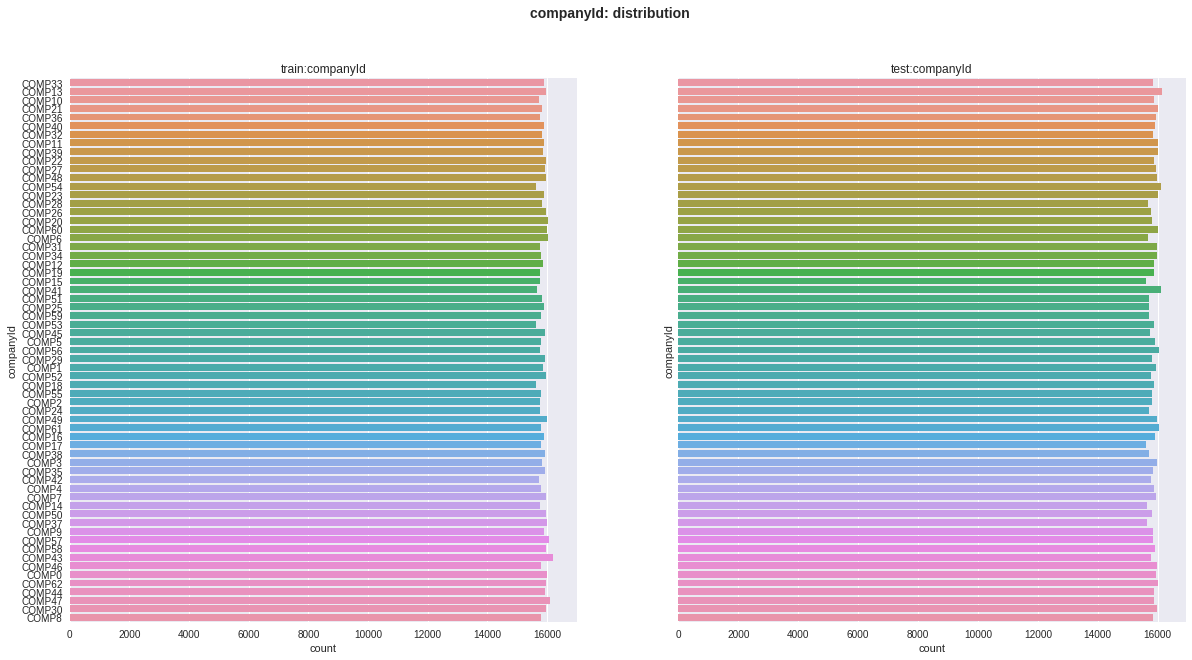

In [0]:
hr_data.plot_variable("companyId")

It seems that all 63 companies have more or less the same number of employees, which is strange! At least, we can say that company size is probably not going to affect predictions much.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


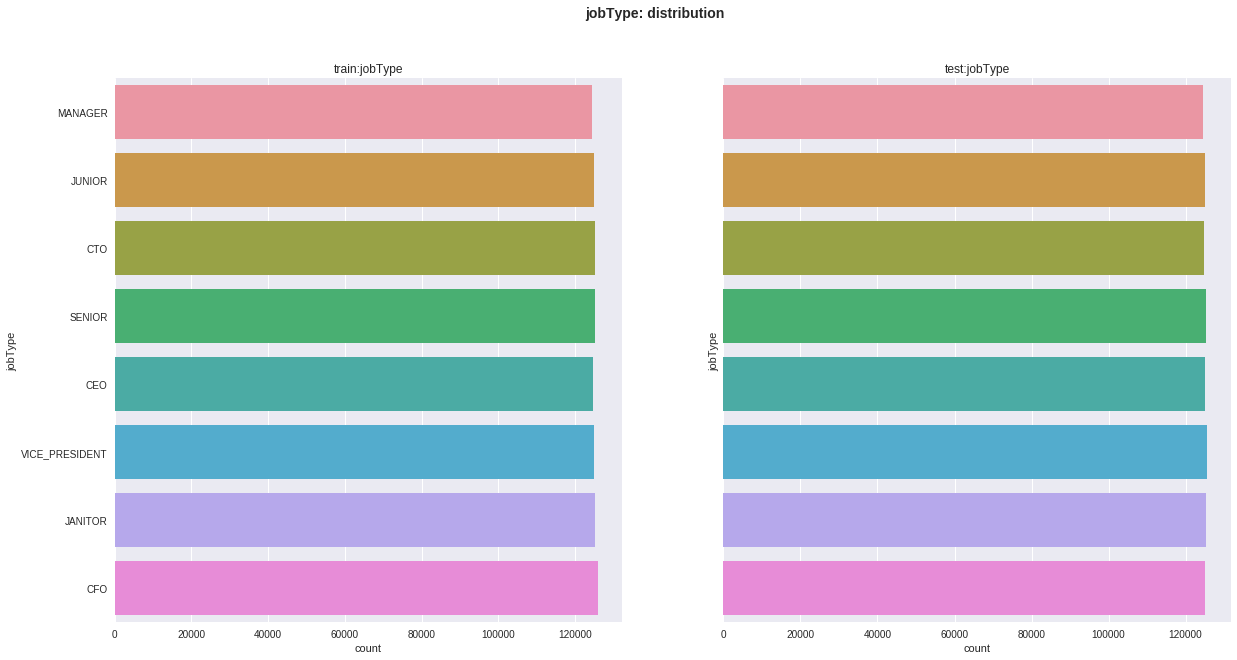

In [0]:
hr_data.plot_variable("jobType")

The job titles are also, curiosly, evenly distributed. Indeed, we can verify the same with industry, yearsExperience and milesFromMetropolis.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


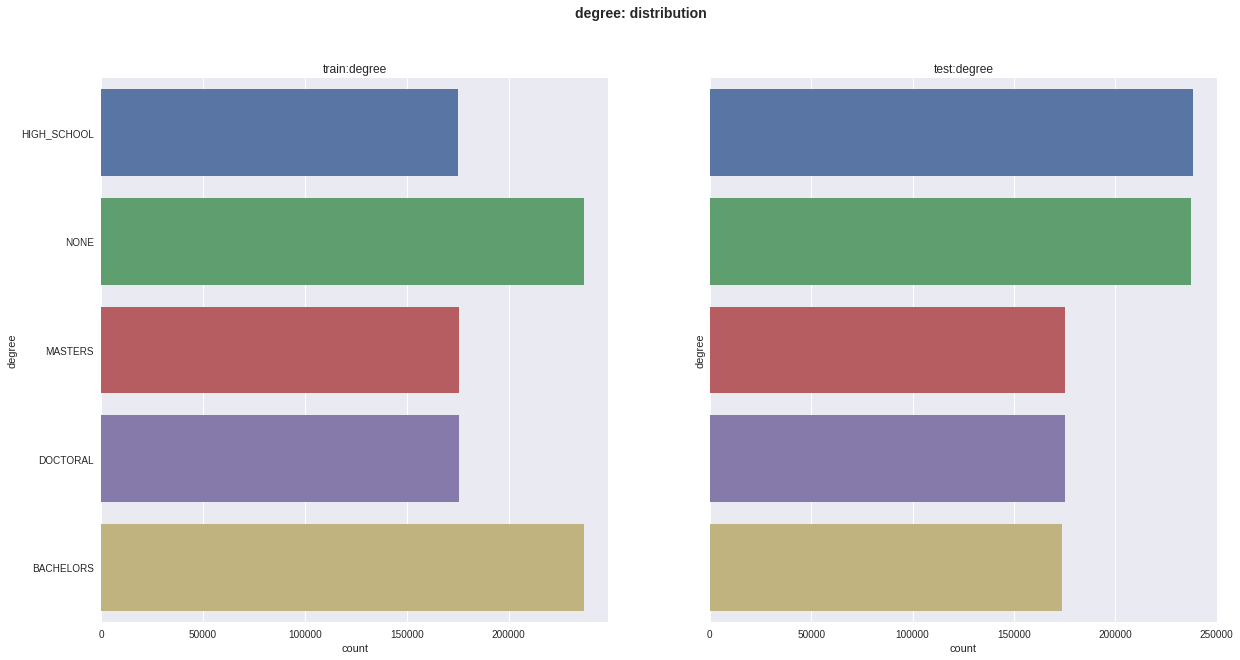

In [0]:
hr_data.plot_variable("degree")

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


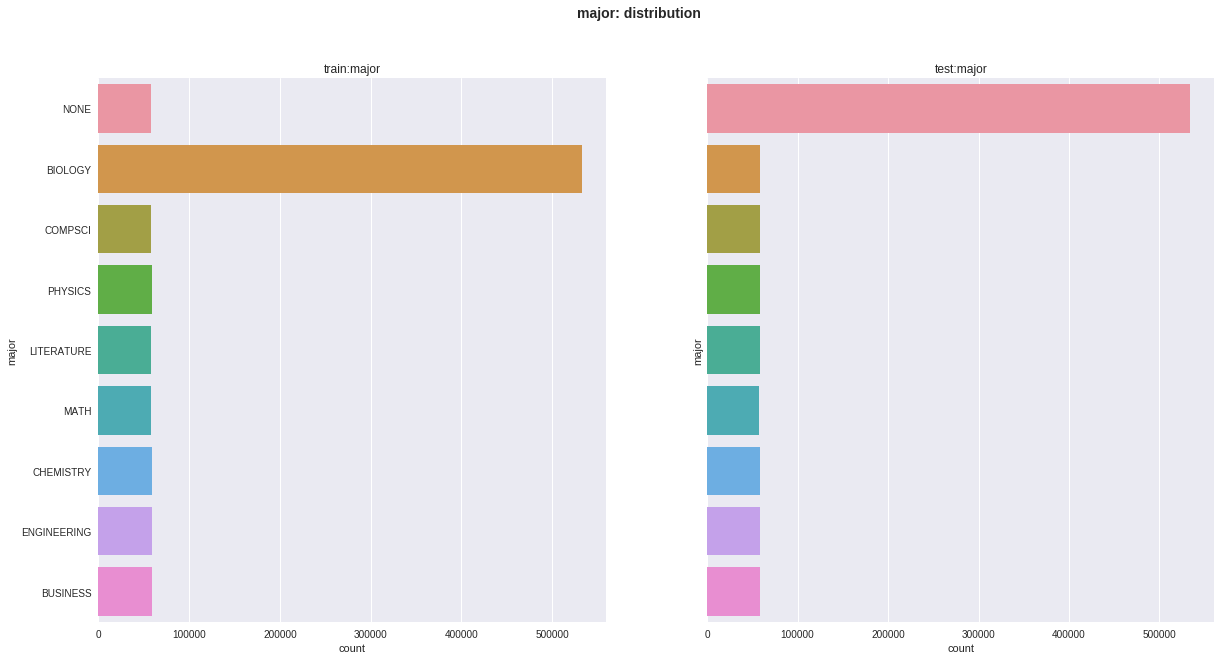

In [0]:
hr_data.plot_variable("major")

Degree and major are different. Both are biased towards the lower levels of education, with NONE being around ten times more frequent than all other majors and "high school" and "none" being the most frequent values among the *degree* categories.

How are *degree* and *major* correlated?

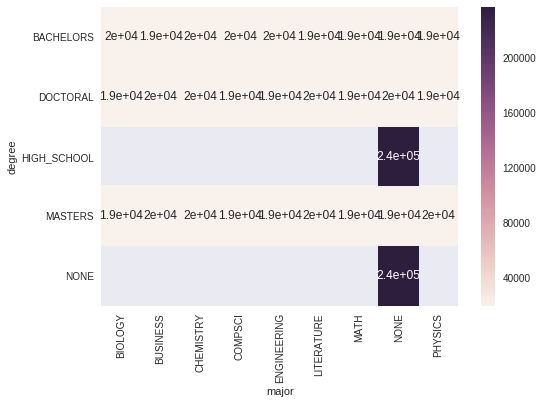

In [0]:
# using len in order to count the co-occurencies.
# then heatmap to dislay them
pivot = hr_data.merged.loc["train"][["degree","major"]].\
        pivot_table(index="degree",columns="major", aggfunc=len)
sb.heatmap(pivot, annot=True)

As expected, all employees with no degree or just high-school education will have "none" as major, but the reverse is not true: "none" seems to be just as likely as any other major value for all the higher education levels.

Let's now have a look at the salary. Hopefully, it is not uniformly distributed as many of the features.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


NormaltestResult(statistic=nan, pvalue=nan)


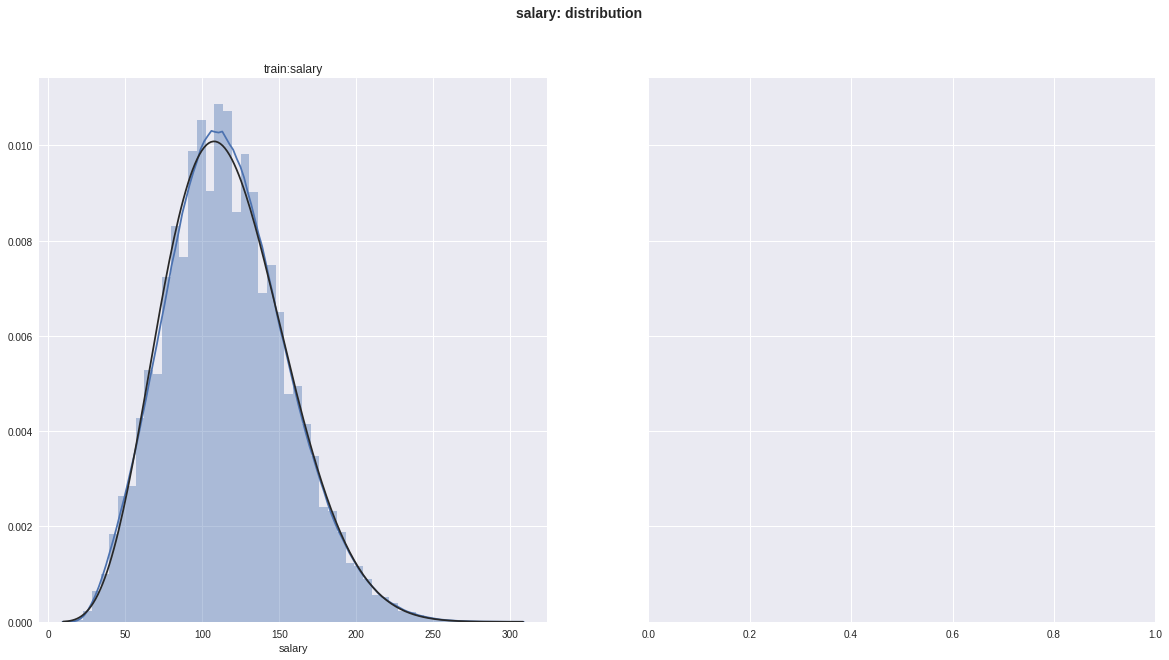

In [0]:
#How are salary distributed in general? Let's fit the series with a Beta distribution
hr_data.plot_variable("salary", fit=beta)
#check for normality
print(normaltest(hr_data.merged.loc["train"]["salary"]))

As we can see, salaries seems to be distributed with a central distribution. Performing a simple normality test makes us exclude the hypothesis that salaries are normally distributed - they possibly follow a beta distribution with a good amount of right skeweness - relatively many very high salaries.

###Relation of the features with the target

We can now move to explore in some detail the possible relations of each of the features with the salary. We hope to extract some useful information in order to formulate an educated hypothesis on the models to consider for the prediction.

Let's start by creating a joint table for features and the salary.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


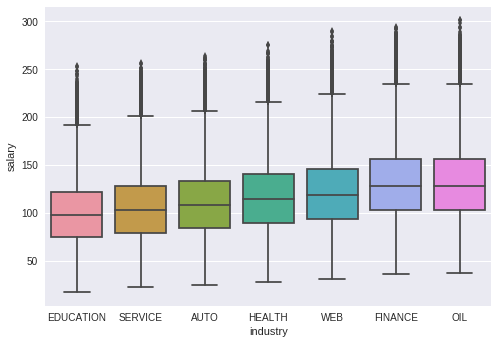

In [0]:
# Distributions of salaries over features can also be synthetically checked with boxplots,
# in which it is easier to show whether a particular value of the features has a significantly
# different mean or variance.


hr_data.plot_vs_target("industry")

While the salary distributions per industry are not *extremely* different, there is some interesting variation. We can note that *Service* and *Education* command lower salaries than all other industries, while *Finance* and *Oil* have indeed a higher mean salary.

We could, only for this time, try and see whether such a variation between salaries is a statistically meaningful one. A good, nonparametric, overall test for the analysis of the variance is the Kruskall-Wallis test.

In [0]:
#split the salary columns into different series by industry
salary_industry_arr = []
for ind in hr_data.merged["industry"].dropna().unique():
    salary_industry_arr.append(hr_data.merged.loc["train"]\
                               [hr_data.merged.loc["train"]["industry"]==ind]["salary"].values)

# Kruskal/Wallis nonparametric omnibus test, just to check whether
# the differences seen above are significant
kruskal(*salary_industry_arr)

KruskalResult(statistic=83284.30288773275, pvalue=0.0)

The resulting statistic is quite high, with a almost null p value. Of course, this does not tell us much other than there is a significant overall variation (whithout identifying *which features* are significantly different) - but at least it tells us we are not looking at an irrelevant difference. We will assume that similar differences between variables will be significant from now on, without any further *post-hoc* analysis.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


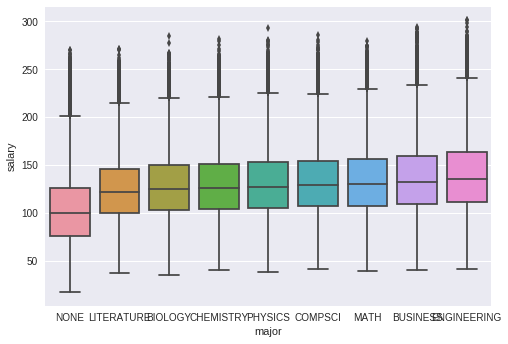

In [0]:
hr_data.plot_vs_target("major")

Here, not having a major seems to be significantly and negatively affetting the salary. Of course, we expect that the result is strongly linked to the general education level. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


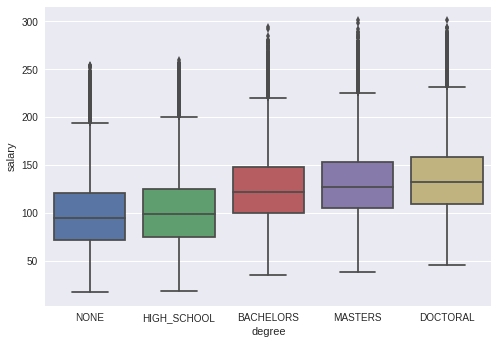

In [0]:
hr_data.plot_vs_target("degree")

As expected, having a *high_school* or a *none* level of education is linked to significantly lower salaries.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


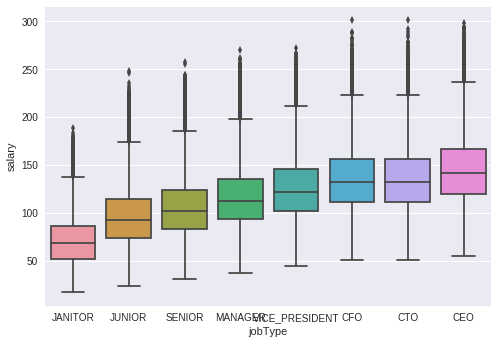

In [0]:
hr_data.plot_vs_target("jobType")

Of course, salaries are expected to be tied to job titles. In the box plot roles like *janitor* and *junior* clearly lie under the 100k dollar stickyard, while *CEO* is slightly under 150.

We could now turn to examining the relationships between the continuous variables. As we noticed before, *milesFromMetropolis* and *yearsExperience* do not have an interesting distribution by themselves. In order to extract some more information, we will also control the graphs by a categorical variable, *jobType*:

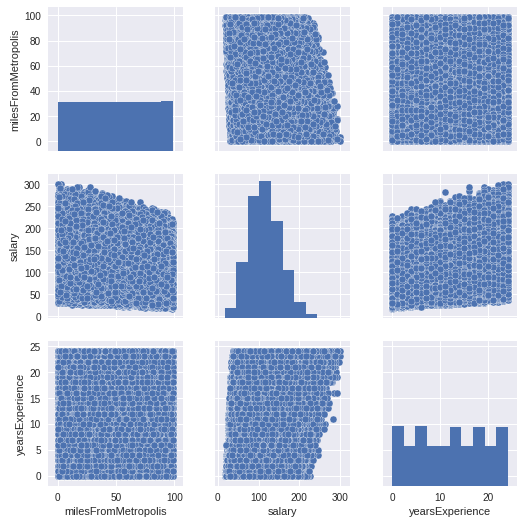

In [0]:
# We could try to extract more information from pair plots,
# for example by checking whether there are any relations between
# continuous variables and controlling by degree or industry
sb.pairplot(hr_data.merged.loc["train"].dropna(),\
            vars=hr_data.numericals,\
            kind="scatter")

The data seem quite noisy and it would be difficult to identify an accurate relation. We can identify two "cap" trends, which we could intepret this way: the longer the experience, the higher the maximum salary; and the higher the salary, the lower the maximum distance.

There is absolutely no interaction between experience and distance from the city.

Now, let's turn our eye to the misterious companyId variable. To analyze this variable better, we will
- create a pivot table of companyId with other categorical variables (mean based)
- check whether there are significant interactions through a heatmap

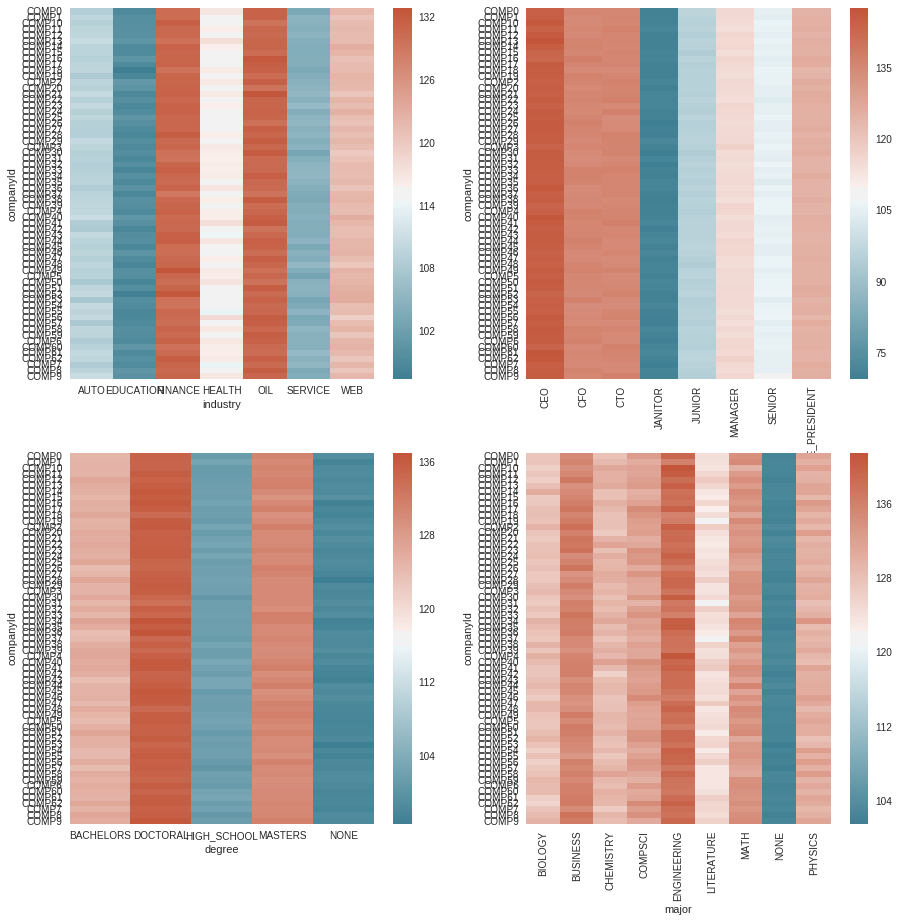

In [0]:
# create a heatmap based on pivot tables with mean aggregate
def hmap_pivot_mean(data, x, y, target, ax):
    sb.heatmap(data.pivot_table(index=x,columns=y,values=target, aggfunc=np.mean),\
               cmap=sb.diverging_palette(220, 20, as_cmap=True), ax=ax)

fig_comp,ax_comp = plt.subplots(figsize=(15,15), nrows=2,ncols=2)


hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="industry",target="salary", ax=ax_comp[0][0])
hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="jobType",target="salary", ax=ax_comp[0][1])
hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="degree",target="salary", ax=ax_comp[1][0])
hmap_pivot_mean(data=hr_data.merged.loc["train"].dropna(),\
                x="companyId",y="major",target="salary", ax=ax_comp[1][1])


Uhm. It seems that this variable is almost completely noise. We have some doubt it might bring some kind of information together with the major. Might it be that some companies are privileging some kind of major over others? Let's give companyId some hope in that direction and let's refrain from deleting it right now.

###Defining a valid reference point for performance evaluation

We need to establish a baseline in order to understand what value a ML model is adding to the processes of a typical company that might use salary data like these.

In this case, we can assume that an hypothetical company owning the current dataset has already created **relatively simple tables** with the average salary for a certain number of clusters of jobs.

How to choose which segments are relevant to build such a table?
Again, we are assuming that the table size must be a *good compromise between accuracy and usability* - we do not want to manage thousands of different segments.

Based on the box plots above, we see that a good part of the variance seems to be explained by the differences in **Job Title** and in **Industry**. Of course, having a major in STEM versus not having a degree also seems to have statistically significant effects, but we do not want to make the reference table unwieldy for the users.

Let's try then to create a reference table of salaries by industry and job title. This should result in a 7x8 table, simple enough for manual consultation.

In [0]:
# We create a toy model based on what we have seen before.
# We will ignore the slight cap effect of experience and distance from the city for now.
# We will use a 8x7 table created by crossing the major with the industry

# We will use the Mean Squared Error to assess the performance of the model,
# through a 5-fold crossvalidation
class TableModel:

    def __init__(self, data, ref_variables):
        self.train = data.get_train(dropna=True)
        self.variables = ref_variables
        self.target = data.target_col
        
    def cv_train(self, folds):

        n_fold_cv = KFold(n_splits=folds, shuffle=True)

        MSE = 0

        # TRAINING/VALIDATION FOLD
        for i in range(folds):
            split = next(n_fold_cv.split(self.train))
            this_train_set = self.train.iloc[split[0]][self.variables + [self.target]]
            this_valid_set = self.train.iloc[split[1]][self.variables + [self.target]]

            # "TRAINING"
            # create the table-model (n major values x m industry values)
            ref_table = this_train_set.groupby(self.variables)[self.target].mean().reset_index()

            # "VALIDATION"
            # split the validation set in features and target
            # then estimate the salary based on the table above
            valid_target = this_valid_set.pop(self.target).values
            est_target = this_valid_set[self.variables].merge(ref_table, how="left")[self.target].values

            MSE += np.mean((valid_target - est_target)**2)

        # Calculate the average MSE of the 5-fold CV
        baseline_MSE = MSE/folds
        return (ref_table, baseline_MSE)

In [0]:
ind_job_table = TableModel(hr_data, ["jobType","industry"])
table_res = ind_job_table.cv_train(5)
print(table_res[1])

831.735777930741


As we can see, using a relatively simple reference table, which does not even use all of the features, we are able to obtain a Mean Square Error of slightly above 800. Roughly speaking, we should expect to guess a salary within a range of +/- 29k dollars, which is the square root of the error.

Is it good enough? A gross metrics to judge the goodness of this error could be the ratio of the root mean squared error to the standard deviation of salary for the general population - that is, roughly, the improvement over picking the average salary of the whole dataset:

In [0]:
np.sqrt(table_res[1])/hr_data.get_train()["salary"].std()

0.744884882891727

The RMSE is 74% of the standard deviation. This is of course an improvement, but definitely not a major one. Can we do better, say at least below 50%? This would correspond to a MSE of around 370.

In [0]:
(0.5*hr_data.get_train()["salary"].std())**2

374.75468514606985

##Looking for better solutions

The table-based model above (with only about 60 parameters) performs decently with a validation MSE just above 800, but clearly it does not make use of several features in the model, most notably:
1. linear cap effects of experience (ascending) and distance from the city (descending)
2. peculiarities of each company
3. job seniority

In fact, it does not take into account any feature interaction other than the couple jobType/industry.

With 1 million rows and virtually no unbalances in the value distributions for each feature, the dataset is robust enough to be attacked with several low bias learning algorithms, including neural networks, with sufficient regularization.
Other choices might include:
 - Linear regression models, specifically regularized models such as Lasso or Ridge. This has the advantage of having minimal training times, but we expect a higher bias
 - Decision (regression) trees regressors, in particular in ensemble (e.g. Random Forests). This class of models is known to perform fairly well on a wide range of problems

It might be useful to consider the nature of the dataset, which has mixed categorical/numerical features.
Using neural networks, kNNs or random forests through sklearn requires transforming the categorical variables into dummy variable or one-hot encoded factors.
If you want to preserve categories as they are and use RF, you might avail of H20, which boasts one of the fastest RF algorithms and can handle categories natively. (http://docs.h2o.ai)

We will keep on with sklearn and proceed to engineer our dataset this time.

### Engineering features

Considering the three models we are going to test, and the number of training examples, we could operate two simple transformations:

1. **Add or transform features:** we are going to transform some of the existing categorical features into ordinal ones. Also, we are introducing new features as aggregate statistics from existing ones. 
2.  **"Dummify" the categorical features**: transform each categorical variable into binary features. Since we are going to use linear models such as Lasso and Ridge, to minimize the risk of multicollinearity it is better to use a dummy strategy, that is, reduce the number of features into n-1 categories, so that the nth is not construed as the linear combination of the others (regularization should take care of this problem already, to some extent)
3.  **Normalize the features**: with the exception of the dummies, all the continuous features. It is not necessary to normalize the target value (why? See [here](https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re)) 

After applying these transformations, we can finally detach the salary into the target, to be fed into our models.

An important action we should take before experimenting with our models is to **prepare a small validation set**. Even if we are going to use cross-validation for Random Forests and Lasso/Ridge, it is safer to reserve  small portion of the data to have a final validation with examples that have not been used for parameter tuning.
Of course, we *are not going to use the validation score to adjust parameters*. It will be the final, official score of each model.

#### a. transform jobType and degree into an ordinal variable
As you can see from the dictionary below, we will merge two of the levels, CFO and CTO, as their mean salary is basically the same and we do not have evidence that a CXO position other than CEO should have a priority over the others.
All other jobType levels seem to follow a clear order.

In [0]:
job_dict = {"JANITOR":0, "JUNIOR":1, "SENIOR":2, "MANAGER":3, "VICE_PRESIDENT":4, "CFO":5,\
           "CTO":5, "CEO": 6}
hr_data.dict_replace("jobType",job_dict)

hr_data.merged.head()

companyId       degree industry             jobId jobType    major  \
test 0    COMP33  HIGH_SCHOOL   HEALTH  JOB1362685407687       3     NONE   
     1    COMP13         NONE     AUTO  JOB1362685407688       1     NONE   
     2    COMP10      MASTERS   HEALTH  JOB1362685407689       5  BIOLOGY   
     3    COMP21  HIGH_SCHOOL      OIL  JOB1362685407690       3     NONE   
     4    COMP36     DOCTORAL      OIL  JOB1362685407691       1  BIOLOGY   

        milesFromMetropolis  salary  yearsExperience  
test 0                 73.0     NaN             22.0  
     1                 47.0     NaN             20.0  
     2                  9.0     NaN             17.0  
     3                 96.0     NaN             14.0  
     4                 44.0     NaN             10.0

There seems to be a clear and clean order between the levels of "degree", therefore we will transform this feature into an ordinal one as well.

In [0]:
# Transform the degree variable into an ordinal number

degree_dict = {"NONE":0, "HIGH_SCHOOL":1, "BACHELORS":2, "MASTERS":3, "DOCTORAL":4}

hr_data.dict_replace("degree",degree_dict)
hr_data.merged.head()

,degree,jobId,milesFromMetropolis,salary,yearsExperience,groupMean,groupMedian,groupVar,companyId_0.0,companyId_1.0,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
level_0,,,,,,,,,,,,,,,,,,,,,
test,1.0,JOB1362685407687,73.0,NaN,22.0,105.814341,103.0,647.070331,0,1,...,0,1,0,0,0,0,1,0,0,0
test,0.0,JOB1362685407688,47.0,NaN,20.0,75.153093,71.0,501.026108,0,0,...,0,1,0,1,0,0,0,0,0,0
test,3.0,JOB1362685407689,9.0,NaN,17.0,152.258683,150.0,880.367056,0,0,...,0,0,0,0,0,0,1,0,0,0
test,1.0,JOB1362685407690,96.0,NaN,14.0,120.113867,117.0,746.393008,1,0,...,0,1,0,0,0,0,0,1,0,0
test,4.0,JOB1362685407691,44.0,NaN,10.0,117.881266,114.0,743.432955,1,0,...,0,0,0,0,0,0,0,1,0,0


#### b. Create a group-mean variable

In [0]:
hr_data.create_grouped_stats(["jobType","major","degree","industry"])
hr_data.merged.head()

,companyId,degree,industry,jobId,jobType,major,milesFromMetropolis,salary,yearsExperience,groupMean,groupMedian,groupVar
level_0,,,,,,,,,,,,
test,COMP33,HIGH_SCHOOL,HEALTH,JOB1362685407687,3,NONE,73.0,NaN,22.0,105.814341,103.0,647.070331
test,COMP13,NONE,AUTO,JOB1362685407688,1,NONE,47.0,NaN,20.0,75.153093,71.0,501.026108
test,COMP10,MASTERS,HEALTH,JOB1362685407689,5,BIOLOGY,9.0,NaN,17.0,152.258683,150.0,880.367056
test,COMP21,HIGH_SCHOOL,OIL,JOB1362685407690,3,NONE,96.0,NaN,14.0,120.113867,117.0,746.393008
test,COMP36,DOCTORAL,OIL,JOB1362685407691,1,BIOLOGY,44.0,NaN,10.0,117.881266,114.0,743.432955


#### c. Clustering companyId
We have already seen that companyId seems to be quite uninformative, but there might be some chance that combining the company information with the major information might actually grant us some extra info.
We will cluster the combinations of (major, companyId) into 5 clusters according to their salary level.
Then, we will get rid of the original companyId variable.

In [0]:
# create a table with the average salary by
comp_pivot = hr_data.get_train().dropna().pivot_table(index=["companyId"],columns=["major"],\
                                                      values="salary")

kmeans_trans = KMeans(n_clusters=5, n_jobs=-1)

In [0]:
kmeaned_pivot = kmeans_trans.fit(comp_pivot.values)
clusters_dict = dict(zip(comp_pivot.index,kmeaned_pivot.labels_))
hr_data.merged["companyId"].replace(clusters_dict,inplace=True)
hr_data.merged.head()

,companyId,degree,industry,jobId,jobType,major,milesFromMetropolis,salary,yearsExperience,groupMean,groupMedian,groupVar
level_0,,,,,,,,,,,,
test,1.0,HIGH_SCHOOL,HEALTH,JOB1362685407687,3,NONE,73.0,NaN,22.0,105.814341,103.0,647.070331
test,3.0,NONE,AUTO,JOB1362685407688,1,NONE,47.0,NaN,20.0,75.153093,71.0,501.026108
test,4.0,MASTERS,HEALTH,JOB1362685407689,5,BIOLOGY,9.0,NaN,17.0,152.258683,150.0,880.367056
test,0.0,HIGH_SCHOOL,OIL,JOB1362685407690,3,NONE,96.0,NaN,14.0,120.113867,117.0,746.393008
test,0.0,DOCTORAL,OIL,JOB1362685407691,1,BIOLOGY,44.0,NaN,10.0,117.881266,114.0,743.432955


#### d. One-hot encoding the categorical variables

In [0]:
# One-hot encoding pure categorical data

    
hr_data.to_one_hot(["companyId","jobType","major","industry"])
hr_data.merged.head()

,degree,jobId,milesFromMetropolis,salary,yearsExperience,groupMean,groupMedian,groupVar,companyId_0.0,companyId_1.0,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
level_0,,,,,,,,,,,,,,,,,,,,,
test,HIGH_SCHOOL,JOB1362685407687,73.0,NaN,22.0,105.814341,103.0,647.070331,0,1,...,0,1,0,0,0,0,1,0,0,0
test,NONE,JOB1362685407688,47.0,NaN,20.0,75.153093,71.0,501.026108,0,0,...,0,1,0,1,0,0,0,0,0,0
test,MASTERS,JOB1362685407689,9.0,NaN,17.0,152.258683,150.0,880.367056,0,0,...,0,0,0,0,0,0,1,0,0,0
test,HIGH_SCHOOL,JOB1362685407690,96.0,NaN,14.0,120.113867,117.0,746.393008,1,0,...,0,1,0,0,0,0,0,1,0,0
test,DOCTORAL,JOB1362685407691,44.0,NaN,10.0,117.881266,114.0,743.432955,1,0,...,0,0,0,0,0,0,0,1,0,0


In [0]:
# Normalizing the numerical variables;

hr_data.scale(["yearsExperience","milesFromMetropolis","groupMean","groupMedian", "groupVar",\
               "jobType", "degree"], "standard")
hr_data.merged.head()

Now that we have transformed all variables into digits, it is much more easy to verify the correlations with a heatmap.

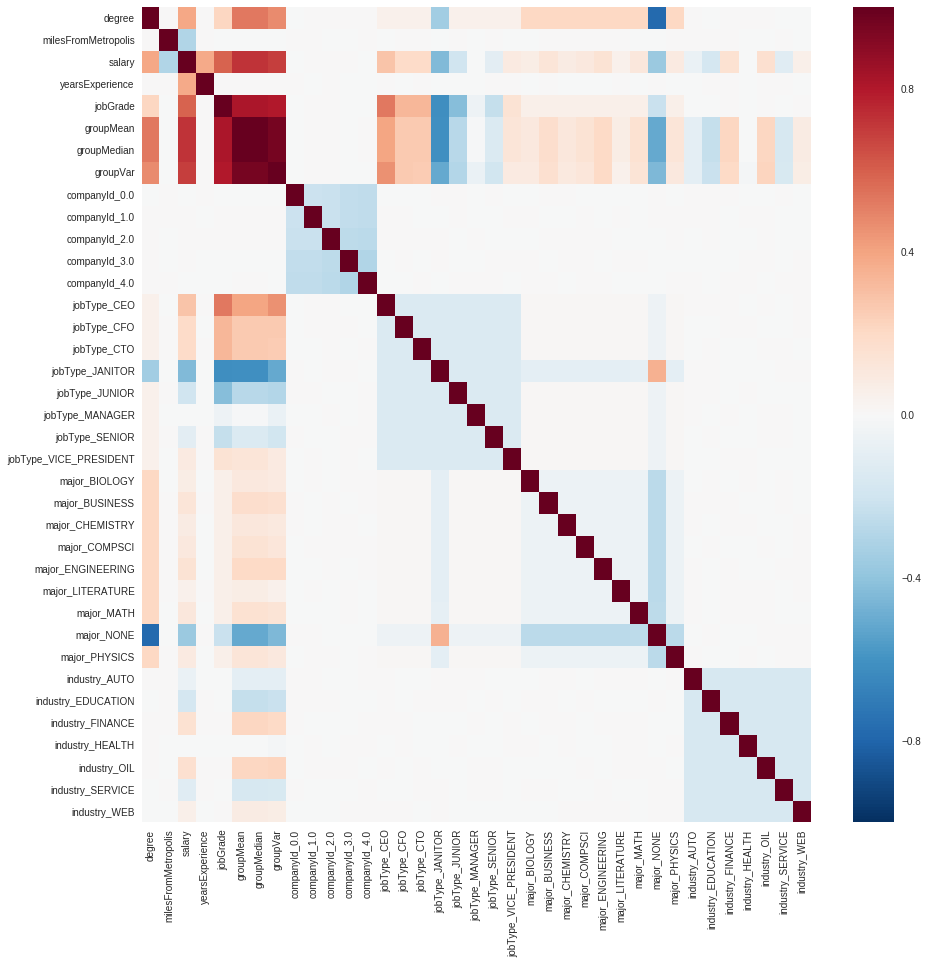

In [0]:
fig, ax = plt.subplots(figsize=(15,15))
sb.heatmap(hr_data.merged.loc["train"].corr())

Oops. It seems that even reducing the company variables there is no noticeable correlation with the salary. We will just drop them.

In [0]:
# Now we can detach the target (salary) from the features
hr_data.merged = hr_data.merged.drop(columns=[hr_data.target_col,"jobId"]+["companyId_{}.0".\
                                         format(i) for i in range(5)])
feat, salaries = hr_data.split_feature_target()

In [0]:
feat, salaries, test_feat = short_track("train_features.csv","test_features.csv","train_salaries.csv")

Creating new Supervised Dataframe instance...
created dataframes with implied target column "salary"
Implied categorical variables: ['companyId', 'degree', 'industry', 'jobId', 'jobType', 'major']
Implied numerical variables: ['milesFromMetropolis', 'salary', 'yearsExperience']
Implied datetime variables: []
information about the train DataFrame:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
companyId              1000000 non-null object
degree                 1000000 non-null object
industry               1000000 non-null object
jobId                  1000000 non-null object
jobType                1000000 non-null object
major                  1000000 non-null object
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null float64
yearsExperience        1000000 non-null int64
dtypes: float64(1), int64(2), object(6)
memory usage: 76.3+ MB
information about the test DataFrame:
<class 'pandas.co

In [0]:
# Since we are going to perform many cross/validated tests to tune the model,
# it is recommendable to keep a few samples for a final validation

train_feat, val_feat, train_salaries, val_salaries = train_test_split(feat,salaries,\
                                                     test_size=0.1, random_state=31)

###Let's initialize the models

As mentioned above we will initialize and tune three families of models:
1. **Regularized linear models**: they are simple, yet robust methods that can deal with numerous features and generalize better than the standard linear regression. The main parameter to set here is alpha, that is, the coefficient of the regularization component in the loss function.
2. **Gradient Boost Models**: this powerful, relatively simple family of models builds on decision trees and learns an ensemble of weak predictors (regressors) to improve generalization while keeping bias low. One definite advantage of GBM over Random Forests is the efficiency of memory and the overall speed.
With lightGBM, which also supports GPUs and parallelism, we are going to experiment on a couple of parameters: the learning rate of the gradient update, the *maximum depth* of each weak learner/tree, and the number of leaves that the algorithm needs to build. Of course, increasing too much max_depth and n_leaves is going to damage generalization and increase the learning time.
3. **Neural Networks**: we will try applying a somewhat vanilla-variety of this powerful family of models. Neural network work very well with many data rows (provided one has the computing power) and have less problems than other models in keeping bias and variance on check, but the number of parameters that needs to be tuned is high, with several nonlinear interferences between one parameter and the others. We will use **Keras** to build a sequential network and try to keep as many defaults as possible.

First, we build our linear regressors. Lasso and Ridge are regularized versions of the classical linear regression. The difference between the two is that Lasso utilizes a L1 regularization (the penalty factor is directly proportional to the weights) while Ridge features a L2 regularization (the penalty and the weights are quadratically related). The practical difference is that Lass tends to create a model with less non-zero features overall. 
For more information: https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/

In [0]:
# Using sklearn Linear_model library to instantiate Lasso and Ridge regressor
# https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
# These values of alpha worked reasonably well
Lasso_reg = Lasso(alpha=0.1)
Ridge_reg = Ridge(alpha=0.1)

Next, we build our LGBM model.
Of course, we are using a GBM *regressor*, which means that the model will spout the level of the output based on the votes of the ensemble learners/trees (which themselves are spouting the mean of the values included in the specific decision segment for each tree).

Although lightgbm offers different parameters to tune, we will make do with the above-mentioned three: learning_rate,  max_depth and n_leaves.

In [0]:
#Using the lightgbm library
#https://lightgbm.readthedocs.io

# These are the parameters that worked better. 
my_gbm = lgbm.LGBMRegressor(learning_rate=0.1, reg_lambda=0.01,\
                            reg_alpha=0.1, n_jobs = -1)

Finally, we implement a simple Neural Networks through Tensorflow and Keras. As the model seems relatively low-dimensional and static, we will build a sequential network with a limited number of layers. Of course the depth of the network as well as the number of neurons per layer will be subject to tuning and validation.

Other than that, we might look into the optimizer to see whether tweaking the learning rate will have some positive effect. We will use Adam as it is relatively stable and most of its parameters can be left alone. Note that we will avail of dropout and batch normalization to respectively regularize the network and improve the accuracy of the final layers.

In [0]:
# Creating a Keras sequential model with dropout
# As this is a regression, the last layer will have a linear activation

my_NN = Sequential([
    Dense(70, activation="elu", input_shape=(23,)),
    Dense(80, activation="elu"),
    Dense(40, activation="elu"),
    Dense(13, activation="elu"),
    Dense(40, activation="elu"),
    Dense(40, activation="elu"),
    Dense(1, activation="linear"),
    ])

Instructions for updating:
Colocations handled automatically by placer.


### Tuning and cross-validation of the models

In [0]:
# We are using mean_squared_error as error metric

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

In [0]:
# L1 regularization regression with 5-fold CV
Lasso_scores = cross_validate(Lasso_reg, train_feat, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.3s finished


In [0]:
# L2 regularization regression with 5-fold CV
Ridge_scores = cross_validate(Ridge_reg, train_feat, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=4, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


In [0]:
# Gradient boost with lightgbm with 5-fold CV
gbm_scores = cross_validate(my_gbm, train_feat, train_salaries,\
                        scoring=mse_scorer ,cv=5, return_train_score=True,\
                        return_estimator=True, verbose=5)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ...................... , score=-355.58648000607633, total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


[CV] ...................... , score=-354.80223791498526, total=   6.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.6s remaining:    0.0s


[CV] ........................ , score=-353.116347664148, total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.2s remaining:    0.0s


[CV] ....................... , score=-353.8768983257895, total=   6.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.2s remaining:    0.0s


[CV] ....................... , score=-356.5947678404413, total=   6.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   44.2s finished


In [0]:
#from keras.optimizers import Adam
#my_opt = Adam(lr=0.001)
my_NN.compile(optimizer="adam", loss="mse")
my_NN.fit(train_feat, train_salaries, validation_split=0.15, epochs=25, batch_size=512)

Instructions for updating:
Use tf.cast instead.
Train on 764995 samples, validate on 135000 samples
Epoch 1/25
764995/764995 [==============================] - 9s 12us/step - loss: 747.5892 - val_loss: 355.7688
Epoch 2/25
764995/764995 [==============================] - 9s 12us/step - loss: 355.9619 - val_loss: 356.5695
Epoch 3/25
764995/764995 [==============================] - 9s 11us/step - loss: 356.0258 - val_loss: 355.7861
Epoch 4/25
764995/764995 [==============================] - 8s 11us/step - loss: 356.0686 - val_loss: 355.9288
Epoch 5/25
764995/764995 [==============================] - 9s 11us/step - loss: 355.5708 - val_loss: 357.4223
Epoch 6/25
764995/764995 [==============================] - 9s 12us/step - loss: 355.8426 - val_loss: 355.6689
Epoch 7/25
764995/764995 [==============================] - 9s 11us/step - loss: 355.5958 - val_loss: 354.8260
Epoch 8/25
764995/764995 [==============================] - 9s 11us/step - loss: 355.4341 - val_loss: 355.7964
Epoch 9/25
7

Let's have a look at the cross-validation score for each of the methods used above.

In [0]:
Lasso_train_score = Lasso_scores["test_score"].mean()
Ridge_train_score = Ridge_scores["test_score"].mean()
GBM_train_score = gbm_scores["test_score"].mean()

print(Lasso_train_score)
print(Ridge_train_score)
print(GBM_train_score)

-370.9018290168202
-370.86411357716923
-354.7953463502881


Among the cross-validated methods, GBM clearly has the upper hand, even if all three algorithms have gone under the treshold of 374 that we set earlier.

Let's have a look at what features has GBM given more weight in training its tree:

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


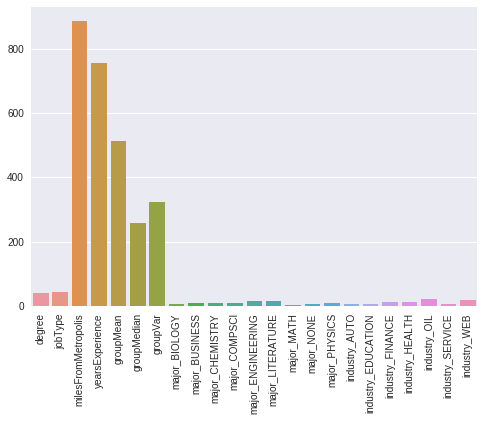

In [0]:
plt.xticks(rotation=90)

sb.barplot(x=train_feat.columns, y=gbm_scores["estimator"][0].feature_importances_)

It seems that milesFromMetropolis, yearsExperience and the group statistics have been given the highest importance in building the boosted tree.

### ---- 10 Select best model  ----

In [0]:
print("Lasso Validation score: {}".\
      format(mean_squared_error(val_salaries,Lasso_scores["estimator"][0].predict(val_feat))))
print("Ridge Validation score: {}".\
      format(mean_squared_error(val_salaries,Ridge_scores["estimator"][0].predict(val_feat))))
print("GBM validation score: {}".\
     format(mean_squared_error(val_salaries,gbm_scores["estimator"][3].predict(val_feat))))
print("NN validation score: {}".\
     format(my_NN.evaluate(val_feat,val_salaries)))

Lasso Validation score: 371.91568724469124
Ridge Validation score: 371.8672176479095
GBM validation score: 355.85404344952474
100000/100000 [==============================] - 2s 20us/step
NN validation score: 354.6875056152344


GBM validation score is on par with the Neural Network performance, despite the significantly faster training time. We are going to use GBM for the production data.!

In [0]:
# training GBM on the whole training set
whole_gbm = my_gbm.fit(feat,salaries)
predictions = whole_gbm.predict(test_feat)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


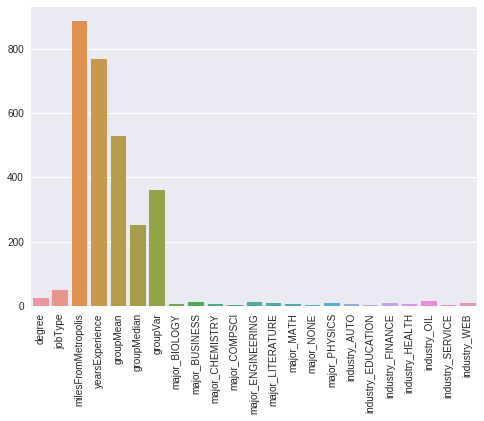

In [0]:
plt.xticks(rotation=90)

sb.barplot(x=train_feat.columns, y=whole_gbm.feature_importances_)

In [0]:
#original_test = pd.read_csv(file_base + "test_features.csv")
#original_test["predictions"] = predictions
original_test.head(20)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,predictions
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,112.423015
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,92.784697
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,178.859954
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,104.025965
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,115.100383
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23,152.309887
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32,99.885563
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73,119.125230
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78,105.483948
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97,98.321949


In [0]:
original_test.to_csv(file_base+"results.csv")